In [ ]:
# 📦 1. Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [6]:
# 📁 2. Load AQI Label File
aqi_df = pd.read_csv(r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\Delhi_AQI_All_Info.csv')
print(aqi_df[['Filename', 'AQI', 'AQI_Class']].head())

                            Filename  AQI         AQI_Class
0    DEL_VUnH_2023-02-04-17.00-1.jpg  281  e_Very_Unhealthy
1   DL_VUNH_2023-02-04-17.00-1-1.jpg  281  e_Very_Unhealthy
2  DL_VUNH_2023-02-04-17.00-1-10.jpg  281  e_Very_Unhealthy
3  DL_VUNH_2023-02-04-17.00-1-11.jpg  281  e_Very_Unhealthy
4  DL_VUNH_2023-02-04-17.00-1-12.jpg  281  e_Very_Unhealthy


In [7]:
# Normalize filenames for easier matching
aqi_df['Filename'] = aqi_df['Filename'].str.strip()

In [ ]:
# Base folders for classes
base_dirs = {
    'd_Unhealthy': r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\d_Unhealthy',
    'e_Very_Unhealthy': r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\e_Very_Unhealthy',
    'f_Severe': r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\f_Severe'
}
IMG_SIZE = (128, 128)

images = []
aqi_values = []
aqi_classes = []



In [ ]:
from tqdm import tqdm

# Ensure filenames in both CSV and folder are consistent
aqi_df['Filename'] = aqi_df['Filename'].str.strip().str.lower()

images = []
aqi_values = []
aqi_classes = []

for folder_name, folder_path in base_dirs.items():
    print(f"🔍 Scanning folder: {folder_name}")
    for fname in tqdm(os.listdir(folder_path)):
        fname_clean = fname.strip().lower()
        full_path = os.path.join(folder_path, fname)

        # Match CSV entry (ignore full match, just check if fname starts with the same prefix)
        matched = aqi_df[aqi_df['Filename'].str.contains(fname_clean.split('.')[0])]
        if matched.empty:
            print(f"⚠️ No match in CSV for: {fname}")
            continue

        try:
            # Load image
            img = load_img(full_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0

            # Use first match
            images.append(img_array)
            aqi_values.append(matched.iloc[0]['AQI'])
            aqi_classes.append(matched.iloc[0]['AQI_Class'])

        except Exception as e:
            print(f"❌ Error loading {fname}: {e}")

print(f"\n✅ Successfully loaded {len(images)} matched images.")


🔍 Scanning folder: d_Unhealthy


  0%|          | 0/123 [00:00<?, ?it/s]

100%|██████████| 123/123 [00:00<00:00, 489.36it/s]


🔍 Scanning folder: e_Very_Unhealthy


100%|██████████| 986/986 [00:02<00:00, 452.01it/s]


🔍 Scanning folder: f_Severe


100%|██████████| 1059/1059 [00:02<00:00, 475.76it/s]


✅ Successfully loaded 2168 matched images.


In [10]:
# Encode classes
le = LabelEncoder()
class_encoded = le.fit_transform(aqi_classes)
class_onehot = to_categorical(class_encoded)

X = np.array(images)
y_aqi = np.array(aqi_values)
y_class = class_onehot

print("✅ AQI Classes:", le.classes_)

✅ AQI Classes: ['d_Unhealthy' 'e_Very_Unhealthy' 'f_Severe']


In [11]:
# 📊 5. Prepare Dataset
X = np.array(images)
y_aqi = np.array(aqi_values)
y_class = class_onehot

X_train, X_test, y_train_reg, y_test_reg, y_train_cls, y_test_cls = train_test_split(
    X, y_aqi, y_class, test_size=0.2, random_state=42
)


In [12]:
# 🧠 6. Define CNN Model
inp = Input(shape=(128, 128, 3))
x = Conv2D(32, (3,3), activation='relu')(inp)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

out_reg = Dense(1, name='aqi_output')(x)
out_cls = Dense(len(le.classes_), activation='softmax', name='class_output')(x)

model = Model(inputs=inp, outputs=[out_reg, out_cls])
model.compile(
    optimizer=Adam(0.001),
    loss={'aqi_output': 'mse', 'class_output': 'categorical_crossentropy'},
    metrics={'aqi_output': 'mae', 'class_output': 'accuracy'}
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 57600)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  7,372,928 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aqi_output (Dense)  │ (None, 1)         │        129 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 3)         │        387 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,392,836 (28.20 MB)

 Trainable params: 7,392,836 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# 🏋️‍♂️ 7. Train the Model
history = model.fit(
    X_train,
    {'aqi_output': y_train_reg, 'class_output': y_train_cls},
    validation_data=(X_test, {'aqi_output': y_test_reg, 'class_output': y_test_cls}),
    epochs=25,
    batch_size=32
)


Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - aqi_output_loss: 38510.1133 - aqi_output_mae: 156.1464 - class_output_accuracy: 0.3245 - class_output_loss: 26.3332 - loss: 38543.6875 - val_aqi_output_loss: 5601.2778 - val_aqi_output_mae: 55.1924 - val_class_output_accuracy: 0.4931 - val_class_output_loss: 5.7271 - val_loss: 5611.5200
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - aqi_output_loss: 7221.4746 - aqi_output_mae: 64.9005 - class_output_accuracy: 0.4580 - class_output_loss: 20.3144 - loss: 7242.8296 - val_aqi_output_loss: 4928.3213 - val_aqi_output_mae: 52.9532 - val_class_output_accuracy: 0.4516 - val_class_output_loss: 7.1106 - val_loss: 4929.3379
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - aqi_output_loss: 6104.0342 - aqi_output_mae: 61.1718 - class_output_accuracy: 0.4616 - class_output_loss: 18.3717 - loss: 6122.7822 - val_aqi_output_loss: 4634.0225 - val_aqi_output_mae: 51.7334 - val_class_output_accuracy: 0.4516 - val_class_output_loss: 8.6984 - 

In [13]:
# Either train the model first
# model.fit(...)

# Or load a previously saved model
from tensorflow.keras.models import load_model
model = load_model("aqi_model.h5", compile=False)


In [14]:
from sklearn.preprocessing import LabelEncoder

# Same order used during training
class_labels = ['d_Unhealthy', 'e_Very_Unhealthy', 'f_Severe']
le = LabelEncoder()
le.fit(class_labels)


LabelEncoder()

In [15]:
# 🔮 8. Predict From New Image
def predict_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred_aqi, pred_class = model.predict(img_array)
    class_label = le.inverse_transform([np.argmax(pred_class)])

    print(f"\n📷 Image: {os.path.basename(image_path)}")
    print(f"🔢 Predicted AQI: {pred_aqi[0][0]:.2f}")
    print(f"🏷️ AQI Class: {class_label[0]}")

In [16]:
# ✅ Example Prediction
predict_image(r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\f_Severe\DEL_SEV_2023-02-07-14.00-1-8.jpg')
predict_image(r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\e_Very_Unhealthy\DEL_VUH_2023-02-04-17.00-2-6.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

📷 Image: DEL_SEV_2023-02-07-14.00-1-8.jpg
🔢 Predicted AQI: 442.18
🏷️ AQI Class: f_Severe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

📷 Image: DEL_VUH_2023-02-04-17.00-2-6.jpg
🔢 Predicted AQI: 294.71
🏷️ AQI Class: e_Very_Unhealthy


In [17]:
# 🔮 8. Predict From New Image
def get_aqi_info(aqi_value):
    if aqi_value <= 50:
        return "Good", "Air quality is considered satisfactory.", "Green"
    elif aqi_value <= 100:
        return "Moderate", "Acceptable air quality; some pollutants may affect sensitive individuals.", "Yellow"
    elif aqi_value <= 150:
        return "Unhealthy for Sensitive Groups", "Sensitive individuals may experience health effects.", "Orange"
    elif aqi_value <= 200:
        return "Unhealthy", "Everyone may begin to experience health effects.", "Red"
    elif aqi_value <= 300:
        return "Very Unhealthy", "Health alert: serious effects for everyone.", "Purple"
    else:
        return "Hazardous", "Health warning of emergency conditions.", "Maroon"
IMG_SIZE = (128, 128)
def predict_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred_aqi, pred_class = model.predict(img_array)
    predicted_value = pred_aqi[0][0]
    class_label = le.inverse_transform([np.argmax(pred_class)])
    
    # 🖼️ Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Get category info
    category, health_message, color = get_aqi_info(predicted_value)

    print(f"\n📷 Image: {os.path.basename(image_path)}")
    print(f"🔢 Predicted AQI: {predicted_value:.2f}")
    print(f"🏷️ AQI Class: {class_label[0]}")
    print(f"📊 AQI Category: {category}")
    print(f"💬 Health Message: {health_message}")
    print(f"🎨 AQI Color: {color}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


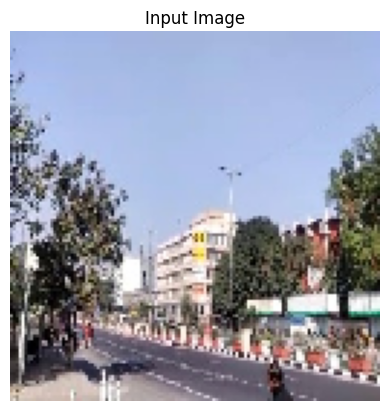


📷 Image: DEL_SEV_2023-02-07-14.00-1-8.jpg
🔢 Predicted AQI: 442.18
🏷️ AQI Class: f_Severe
📊 AQI Category: Hazardous
💬 Health Message: Health warning of emergency conditions.
🎨 AQI Color: Maroon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


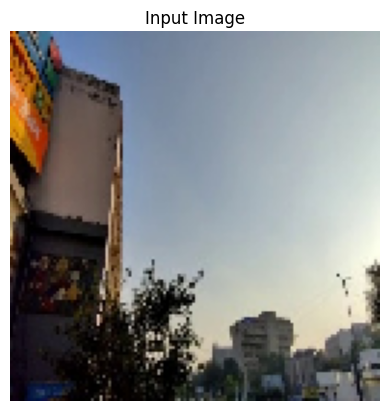


📷 Image: DEL_VUH_2023-02-04-17.00-2-6.jpg
🔢 Predicted AQI: 294.71
🏷️ AQI Class: e_Very_Unhealthy
📊 AQI Category: Very Unhealthy
💬 Health Message: Health alert: serious effects for everyone.
🎨 AQI Color: Purple


In [18]:
# ✅ Example Prediction
predict_image(r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\f_Severe\DEL_SEV_2023-02-07-14.00-1-8.jpg')
predict_image(r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\e_Very_Unhealthy\DEL_VUH_2023-02-04-17.00-2-6.jpg')

In [35]:
predict_image(r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\e_Very_Unhealthy\DEL_VUH_2023-02-04-17.00-2-3.jpg')
predict_image(input("Enter your image path: "))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

📷 Image: DEL_VUH_2023-02-04-17.00-2-3.jpg
🔢 Predicted AQI: 282.50
🏷️ AQI Class: e_Very_Unhealthy
📊 AQI Category: Very Unhealthy
💬 Health Message: Health alert: serious effects for everyone.
🎨 AQI Color: Purple
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

📷 Image: DEL_UnH_2023-02-15-11.30-1-15.jpg
🔢 Predicted AQI: 180.70
🏷️ AQI Class: e_Very_Unhealthy
📊 AQI Category: Unhealthy
💬 Health Message: Everyone may begin to experience health effects.
🎨 AQI Color: Red


In [21]:
model.save("aqi_model.h5", include_optimizer=False)


In [22]:
from tensorflow.keras.models import load_model

# Load without compile
model = load_model("aqi_model.h5", compile=False)


In [32]:
from sklearn.metrics import accuracy_score

# Get class predictions from the model
_, y_pred_class = model.predict(X_test)

# Convert one-hot encoded predictions and labels to class indices
y_true_class = np.argmax(y_test_cls, axis=1)
y_pred_class_labels = np.argmax(y_pred_class, axis=1)

# Classification accuracy
class_accuracy = accuracy_score(y_true_class, y_pred_class_labels)
print(f"🏷️ Classification Accuracy: {class_accuracy:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
🏷️ Classification Accuracy: 0.6705
